# Solución etapa 4 - Training - Predict

In [ ]:
# Utilidades para print
from utils.print_utils import tabl, headr, titl
from utils.explore_utils import explr

In [ ]:
# Importar librerías necesarias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler

from skforecast.recursive import ForecasterRecursive
from skforecast.model_selection import backtesting_forecaster
from skforecast.datasets import fetch_dataset
from skforecast.model_selection import TimeSeriesFold
from skforecast.model_selection import grid_search_forecaster


In [ ]:
version_to_load='v1'

In [ ]:
# Cargar el dataset
csv_path = f'../data/preprocessed/preprocessed_data_{version_to_load}.csv'
print('... Loading:', csv_path,'...')
final_data = pd.read_csv(csv_path)

tabl(final_data)

In [ ]:
final_data.info()

In [ ]:
# Preparación del dato

final_data['Fecha'] = pd.to_datetime(final_data['Fecha'], format='%Y-%m-%d')

In [ ]:
target_column = 'Fallo'

## Extraemos un equipo

In [195]:
eq = 1
equipo = final_data[final_data['ID_Equipo'] == eq].copy()

In [196]:
# Eliminar columnas innecesarias
equipo.drop(columns=['ID_Equipo','Tipo_Equipo','Modelo','Potencia_kW','Horas_Recomendadas_Revision'], inplace=True)

In [197]:
equipo['Fecha'] = pd.to_datetime(equipo['Fecha'], format='%Y-%m-%d')

In [198]:
# fecha como índice
equipo = equipo.set_index('Fecha')

In [199]:
equipo.index

DatetimeIndex(['2021-01-01', '2021-01-03', '2021-01-04', '2021-01-05',
               '2021-01-06', '2021-01-07', '2021-01-08', '2021-01-09',
               '2021-01-10', '2021-01-11',
               ...
               '2024-12-22', '2024-12-23', '2024-12-24', '2024-12-25',
               '2024-12-26', '2024-12-27', '2024-12-28', '2024-12-29',
               '2024-12-30', '2024-12-31'],
              dtype='datetime64[ns]', name='Fecha', length=1462, freq=None)

In [200]:
# Convierte Timeseries a frecuencia especificada.
equipo_fq = equipo_clean.asfreq('D', fill_value=0)
# equipo_fq = equipo_clean.sort_index()
equipo_fq.head(10)

,Vibracion_mm_s,Horas_Operativas,Fallo
Fecha,,,
2021-01-01,2.136812,614,0.0
2021-01-02,0.000000,0,0.0
2021-01-03,1.529395,658,0.0
2021-01-04,3.411009,664,0.0
2021-01-05,0.618757,683,0.0
2021-01-06,4.641474,701,0.0
2021-01-07,9.634196,717,0.0
2021-01-08,9.772868,730,0.0
2021-01-09,6.510735,0,1.0


In [201]:
equipo_fq.index

DatetimeIndex(['2021-01-01', '2021-01-02', '2021-01-03', '2021-01-04',
               '2021-01-05', '2021-01-06', '2021-01-07', '2021-01-08',
               '2021-01-09', '2021-01-10',
               ...
               '2024-12-22', '2024-12-23', '2024-12-24', '2024-12-25',
               '2024-12-26', '2024-12-27', '2024-12-28', '2024-12-29',
               '2024-12-30', '2024-12-31'],
              dtype='datetime64[ns]', name='Fecha', length=1461, freq='D')

In [202]:
# Verificar que un índice temporal está completo

fecha_inicio = equipo_fq.index.min()
fecha_fin = equipo_fq.index.max()
print(fecha_inicio, fecha_fin)

date_range_completo = pd.date_range(start=fecha_inicio, end=fecha_fin, freq=equipo_fq.index.freq)
date_range_completo.shape
print(f"Índice completo: {(equipo_fq.index == date_range_completo).all()}")

2021-01-01 00:00:00 2024-12-31 00:00:00
Índice completo: True


## Separación datos train-test

Fechas train : 2021-01-01 00:00:00 --- 2024-12-16 00:00:00  (n=1446)
Fechas test  : 2024-12-17 00:00:00 --- 2024-12-31 00:00:00  (n=15)


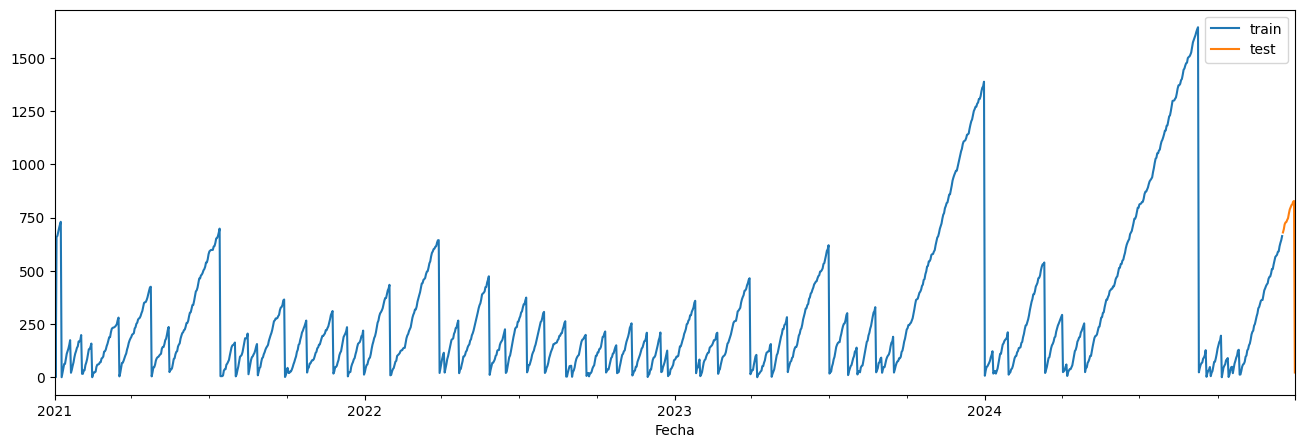

In [203]:
steps = 15
datos_train = equipo_fq[:-steps]
datos_test  = equipo_fq[-steps:]
print(f"Fechas train : {datos_train.index.min()} --- {datos_train.index.max()}  (n={len(datos_train)})")
print(f"Fechas test  : {datos_test.index.min()} --- {datos_test.index.max()}  (n={len(datos_test)})")

fig, ax = plt.subplots(figsize=(16, 5))
datos_train['Horas_Operativas'].plot(ax=ax, label='train')
datos_test['Horas_Operativas'].plot(ax=ax, label='test')
ax.legend();

In [204]:
datos_train.columns

Index(['Vibracion_mm_s', 'Horas_Operativas', 'Fallo'], dtype='object')

##  Forecasting autorregresivo recursivo

In [205]:
# Crear y entrenar forecaster

forecaster = ForecasterRecursive(
    regressor=Ridge(random_state=123),
    lags=480,
)

exogs_train = datos_train.drop(columns=['Horas_Operativas'])

forecaster.fit(y=datos_train['Horas_Operativas'], exog=exogs_train)
forecaster

=================== 
ForecasterRecursive 
=================== 
Regressor: Ridge 
Lags: [  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36
  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54
  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72
  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90
  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108
 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126
 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144
 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162
 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180
 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198
 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216
 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233 234
 235 236 237 238 239 240 241 242 243 244 245 246 247 248 249 250 251 252
 253 254 255 256 257 258 259 260 261 262 263 264 265 266 267 268 269 270
 271 272 273 274 275 276 277 278 279 280 281 282 283 284 285 286 287 288
 289 290 291 292 293 294 295 296 297 298 299 300 301 302 303 304 305 306
 307 308 309 310 311 312 313 314 315 316 317 318 319 320 321 322 323 324
 325 326 327 328 329 330 331 332 333 334 335 336 337 338 339 340 341 342
 343 344 345 346 347 348 349 350 351 352 353 354 355 356 357 358 359 360
 361 362 363 364 365 366 367 368 369 370 371 372 373 374 375 376 377 378
 379 380 381 382 383 384 385 386 387 388 389 390 391 392 393 394 395 396
 397 398 399 400 401 402 403 404 405 406 407 408 409 410 411 412 413 414
 415 416 417 418 419 420 421 422 423 424 425 426 427 428 429 430 431 432
 433 434 435 436 437 438 439 440 441 442 443 444 445 446 447 448 449 450
 451 452 453 454 455 456 457 458 459 460 461 462 463 464 465 466 467 468
 469 470 471 472 473 474 475 476 477 478 479 480] 
Window features: None 
Window size: 480 
Exogenous included: True 
Exogenous names: Vibracion_mm_s, Fallo 
Transformer for y: None 
Transformer for exog: None 
Weight function included: False 
Differentiation order: None 
Training range: [Timestamp('2021-01-01 00:00:00'), Timestamp('2024-12-16 00:00:00')] 
Training index type: DatetimeIndex 
Training index frequency: D 
Regressor parameters: 
    {'alpha': 1.0, 'copy_X': True, 'fit_intercept': True, 'max_iter': None,
    'positive': False, 'random_state': 123, 'solver': 'auto', 'tol': 0.0001} 
fit_kwargs: {} 
Creation date: 2025-04-24 07:46:40 
Last fit date: 2025-04-24 07:46:40 
Skforecast version: 0.14.0 
Python version: 3.12.4 
Forecaster id: None

In [206]:
# Predicciones
exogs_test = datos_test.drop(columns=['Horas_Operativas'])

predicciones = forecaster.predict(steps=steps, exog=exogs_test)
predicciones.index = datos_test.index
predicciones

Fecha
2024-12-17    639.243277
2024-12-18    627.769688
2024-12-19    662.879219
2024-12-20    676.850565
2024-12-21    709.432172
2024-12-22    682.552366
2024-12-23    687.960101
2024-12-24    690.911662
2024-12-25    518.448681
2024-12-26    560.327535
2024-12-27    518.341141
2024-12-28    530.972124
2024-12-29    580.530305
2024-12-30    570.193248
2024-12-31    328.287946
Freq: D, Name: pred, dtype: float64

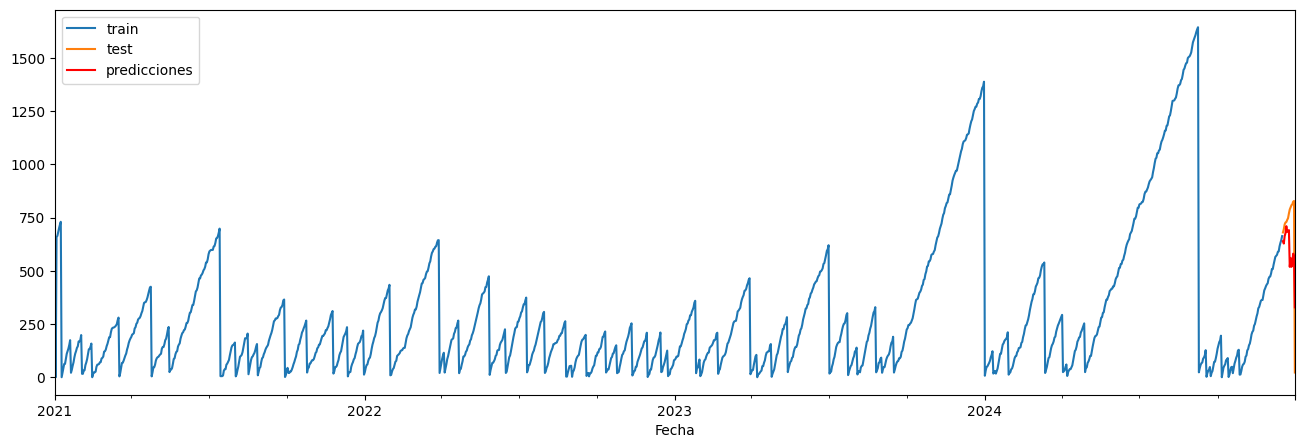

In [207]:
# Gráfico de predicciones vs valores reales

fig, ax = plt.subplots(figsize=(16, 5))
datos_train['Horas_Operativas'].plot(ax=ax, label='train')
datos_test['Horas_Operativas'].plot(ax=ax, label='test')
predicciones.plot(ax=ax, label='predicciones', color="red")
ax.legend()

In [208]:
# Error test

error_mse = mean_squared_error(
    y_true=datos_test['Horas_Operativas'],
    y_pred=predicciones
)

data_var = equipo_fq['Horas_Operativas'].var()

print(f"Error de test (mse): {error_mse}")
print(f"Varianza datos: {data_var}")
print(f"mse2var: {round(error_mse/data_var*100, 2)}%")

Error de test (mse): 35764.41203579863
Varianza datos: 101688.87860257094
mse2var: 35.17%


In [209]:
# Búsqueda de hiperparámetros: grid search

forecaster = ForecasterRecursive(
    regressor=Ridge(random_state=123),
    lags=12,  # Este valor será remplazado en el grid search
)


# Particiones de entrenamiento y validación
cv = TimeSeriesFold(
    steps=steps,
    initial_train_size=int(len(datos_train) * 0.5),
    refit=False,
    fixed_train_size=False,
)

# Valores candidatos de lags
lags_grid = [10, 50, 100, 150]

# Valores candidatos de hiperparámetros del regresor
param_grid = {
    'alpha': [0.1, 1, 10, 100],
}

resultados_grid = grid_search_forecaster(
    forecaster=forecaster,
    y=datos_train['Horas_Operativas'],
    cv=cv,
    param_grid=param_grid,
    lags_grid=lags_grid,
    metric='mean_squared_error',
    return_best=True,
    n_jobs='auto',
    verbose=True,
    exog=exogs_train,
)

Number of models compared: 16.


lags grid:   0%|          | 0/4 [00:00<?, ?it/s]

params grid:   0%|          | 0/4 [00:00<?, ?it/s]

Information of folds
--------------------
Number of observations used for initial training: 723
Number of observations used for backtesting: 723
    Number of folds: 49
    Number skipped folds: 0 
    Number of steps per fold: 15
    Number of steps to exclude between last observed data (last window) and predictions (gap): 0
    Last fold only includes 3 observations.

Fold: 0
    Training:   2021-01-01 00:00:00 -- 2022-12-24 00:00:00  (n=723)
    Validation: 2022-12-25 00:00:00 -- 2023-01-08 00:00:00  (n=15)
Fold: 1
    Training:   No training in this fold
    Validation: 2023-01-09 00:00:00 -- 2023-01-23 00:00:00  (n=15)
Fold: 2
    Training:   No training in this fold
    Validation: 2023-01-24 00:00:00 -- 2023-02-07 00:00:00  (n=15)
Fold: 3
    Training:   No training in this fold
    Validation: 2023-02-08 00:00:00 -- 2023-02-22 00:00:00  (n=15)
Fold: 4
    Training:   No training in this fold
    Validation: 2023-02-23 00:00:00 -- 2023-03-09 00:00:00  (n=15)
Fold: 5
    Training

In [210]:
# Resultados de la búsqueda de hiperparámetros

resultados_grid.sort_values(
    by=['mean_squared_error'],
    ascending=True,
    inplace=True
)

resultados_grid

,lags,lags_label,params,mean_squared_error,alpha
0,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",{'alpha': 0.1},34474.852169,0.1
1,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",{'alpha': 0.1},35473.128487,0.1
2,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",{'alpha': 1},35543.166324,1.0
3,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",{'alpha': 1},36503.772033,1.0
4,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]",{'alpha': 0.1},36795.287387,0.1
5,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]",{'alpha': 1},37638.352783,1.0
6,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]",{'alpha': 10},44879.266924,10.0
7,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",{'alpha': 10},44915.218569,10.0
8,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",{'alpha': 10},45477.576615,10.0
9,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",{'alpha': 0.1},47475.016956,0.1


## Modelo final

In [211]:
# Crear y entrenar forecaster

forecaster = ForecasterRecursive(
    regressor=Ridge(alpha=0.1, random_state=123),
    lags=50,
)

forecaster.fit(y=datos_train['Horas_Operativas'], exog=exogs_train)
forecaster

=================== 
ForecasterRecursive 
=================== 
Regressor: Ridge 
Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50] 
Window features: None 
Window size: 50 
Exogenous included: True 
Exogenous names: Vibracion_mm_s, Fallo 
Transformer for y: None 
Transformer for exog: None 
Weight function included: False 
Differentiation order: None 
Training range: [Timestamp('2021-01-01 00:00:00'), Timestamp('2024-12-16 00:00:00')] 
Training index type: DatetimeIndex 
Training index frequency: D 
Regressor parameters: 
    {'alpha': 0.1, 'copy_X': True, 'fit_intercept': True, 'max_iter': None,
    'positive': False, 'random_state': 123, 'solver': 'auto', 'tol': 0.0001} 
fit_kwargs: {} 
Creation date: 2025-04-24 07:46:44 
Last fit date: 2025-04-24 07:46:44 
Skforecast version: 0.14.0 
Python version: 3.12.4 
Forecaster id: None

In [212]:
# Predicciones

predicciones = forecaster.predict(steps=steps, exog=exogs_test)
predicciones.index = datos_test.index
predicciones

Fecha
2024-12-17    661.637114
2024-12-18    661.595159
2024-12-19    661.302107
2024-12-20    659.733231
2024-12-21    656.366388
2024-12-22    656.385909
2024-12-23    654.314433
2024-12-24    653.651163
2024-12-25    653.658808
2024-12-26    654.410511
2024-12-27    652.948899
2024-12-28    653.034580
2024-12-29    653.166052
2024-12-30    653.504792
2024-12-31    373.926771
Freq: D, Name: pred, dtype: float64

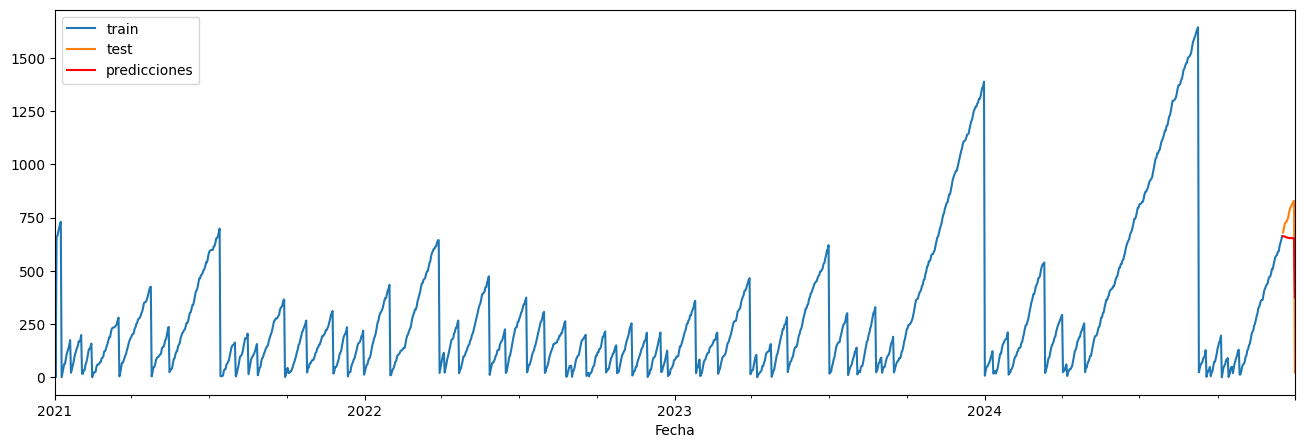

In [213]:
# Gráfico de predicciones vs valores reales

fig, ax = plt.subplots(figsize=(16, 5))
datos_train['Horas_Operativas'].plot(ax=ax, label='train')
datos_test['Horas_Operativas'].plot(ax=ax, label='test')
predicciones.plot(ax=ax, label='predicciones', color="red")
ax.legend()

In [214]:
# Error test

error_mse = mean_squared_error(
    y_true=datos_test['Horas_Operativas'],
    y_pred=predicciones
)

data_var = equipo_fq['Horas_Operativas'].var()

print(f"Error de test (mse): {error_mse}")
print(f"Varianza datos: {data_var}")
print(f"mse2var: {round(error_mse/data_var*100, 2)}%")

Error de test (mse): 20976.72401379287
Varianza datos: 101688.87860257094
mse2var: 20.63%
